# Project 2: Image Processing - Identifying Road Segment From Satellite Images
<hr style="clear:both">

This jupyter notebook contains our journey to train a Random model for road segmentation in aerial images.

Authors: Mahmoud Dokmak, Romain Corbel, Guilhem
<hr style="clear:both">

I. Import

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils.logistic_regression import *
from utils.helpers import *
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.metrics import f1_score, accuracy_score


PATCH_SIZE = 16

II. Load the data

In [3]:
root_training_dir = "dataset/training/"
imgs, gt_imgs, n_train, files_train = load_data(root_training_dir, is_test=False)

# Convert ground truth masks to binary arrays
gt_imgs = [np.array(gt_img > 0.5).astype(int) for gt_img in gt_imgs]

dataset_size = len(imgs)
indices = np.arange(dataset_size)

np.random.seed(42)
np.random.shuffle(indices)

split_ratio = 0.2
split_point = int(dataset_size * (1 - split_ratio))
train_indices = indices[:split_point]
eval_indices = indices[split_point:]

# Create training and evaluation splits
imgs_train = [imgs[i] for i in train_indices]
gt_imgs_train = [gt_imgs[i] for i in train_indices]
imgs_eval = [imgs[i] for i in eval_indices]
gt_imgs_eval = [gt_imgs[i] for i in eval_indices]

print(f"Training set size: {len(imgs_train)}")
print(f"Evaluation set size: {len(imgs_eval)}")

Training set size: 80
Evaluation set size: 20


III. Distribution of 0 and 1 in the training set

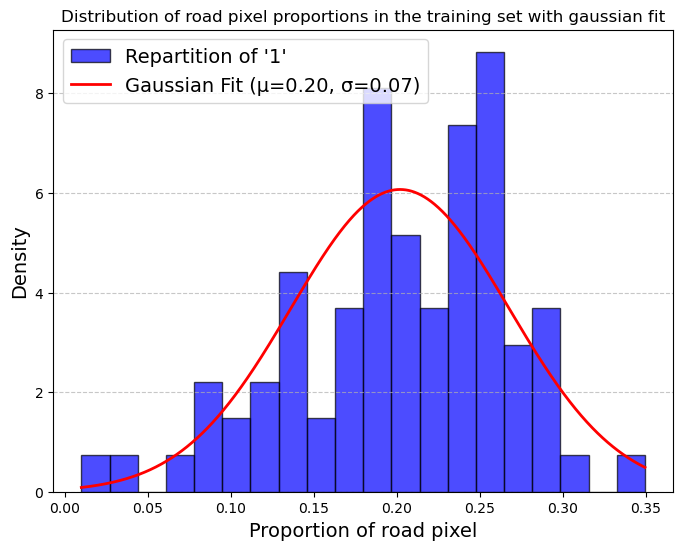

In [4]:
prop_road = []
for gt_img_train in gt_imgs_train:
    prop_road.append(np.mean(gt_img_train))

plt.figure(figsize=(8, 6))
count, bins, _ = plt.hist(
    prop_road,
    bins=20,
    density=True,
    alpha=0.7,
    color="blue",
    edgecolor="black",
    label="Repartition of '1'",
)
mu, sigma = norm.fit(prop_road)
x = np.linspace(min(bins), max(bins), 1000)
pdf = norm.pdf(x, mu, sigma)

plt.plot(x, pdf, "r-", lw=2, label=f"Gaussian Fit (μ={mu:.2f}, σ={sigma:.2f})")
plt.title(
    "Distribution of road pixel proportions in the training set with gaussian fit"
)
plt.xlabel("Proportion of road pixel", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

IV. Sample proportions

Randomly draw proportions from the Gaussian distribution for the evaluation set.

In [5]:
num_values = len(imgs_eval)
np.random.seed(42)
sampled_proportions = np.random.normal(mu, sigma, num_values)
print("Sampled Proportions for Evaluation Set:\n", sampled_proportions)


def generate_random_mask(shape, proportion, random_seed=42):
    rng = np.random.default_rng(random_seed)
    size = np.prod(shape)
    num_ones = int(size * proportion)
    mask = np.zeros(size)
    mask[:num_ones] = 1
    rng.shuffle(mask)
    return mask.reshape(shape)


mask_shape_test = np.shape(gt_imgs_eval[0])
eval_masks = [
    generate_random_mask(mask_shape_test, proportion)
    for proportion in sampled_proportions
]

Sampled Proportions for Evaluation Set:
 [0.23446387 0.19272943 0.24438677 0.30191924 0.18642705 0.18642812
 0.30561191 0.25225718 0.17096039 0.23747712 0.17135848 0.17120651
 0.21772011 0.07606517 0.08844543 0.16486018 0.13524786 0.2224711
 0.14213639 0.10899223]


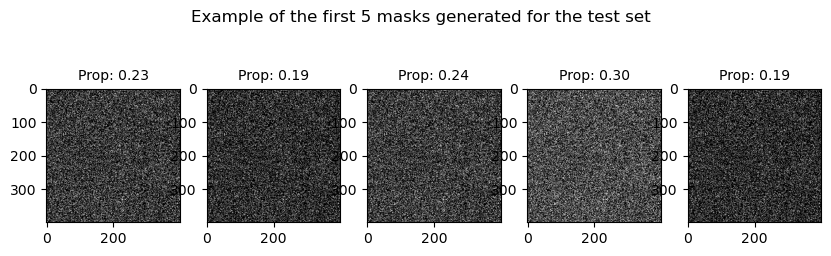

In [6]:
plt.figure(figsize=(10, 3))
plt.suptitle("Example of the first 5 masks generated for the test set")
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(eval_masks[i], cmap="gray")
    plt.title(f"Prop: {sampled_proportions[i]:.2f}", fontsize=10)
plt.show()

V. Evaluation of the model

In [7]:
gt_imgs_eval_flattened = np.array(gt_imgs_eval).ravel()
eval_masks = np.array(eval_masks).ravel()
F1 = f1_score(gt_imgs_eval_flattened, eval_masks)
acc = accuracy_score(gt_imgs_eval_flattened, eval_masks)
print(
    f"For this random model, we have a F1-score of: {F1:.4f} and an accuracy of: {acc:.4f}"
)

For this random model, we have a F1-score of: 0.1894 and an accuracy of: 0.6874
